In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
from datetime import datetime, timedelta
import pytz
import pandas_market_calendars as mcal
import alphalens as al

In [16]:
columns_to_load = ['ticker', 'publication date', 'predicted_sentiment_probabilities']
df = pd.read_csv("170k_data_predictions.csv", usecols=columns_to_load)

## Data Preprocessing

### Adjusting the dates of news articles

In [17]:
df['publication date'] = pd.to_datetime(df['publication date'], errors='coerce')

nyse = mcal.get_calendar('NYSE')

trading_start_hour = 9
trading_start_minute = 30
trading_end_hour = 16
trading_end_minute = 0

def adjust_date(pub_date):
    if pd.isnull(pub_date) or not isinstance(pub_date, pd.Timestamp):
        return pub_date

    trading_end_time = pd.Timestamp(f'{pub_date.date()} {trading_end_hour}:{trading_end_minute}')
    if pub_date >= trading_end_time:
        next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
        return next_trading_day
    else:
        valid_days = nyse.valid_days(start_date=pub_date.date(), end_date=pub_date.date())
        if not valid_days.empty and pub_date.date() == valid_days[0].date():
            return pub_date
        else:
            next_trading_day = nyse.schedule(start_date=pub_date.date() + pd.DateOffset(days=1), end_date=pub_date.date() + pd.DateOffset(days=10)).iloc[0]['market_open']
            return next_trading_day

df['publication date'] = df['publication date'].apply(adjust_date)

TypeError: Cannot compare tz-naive and tz-aware timestamps

### Converting probabiltiies to one value

In [18]:
import ast

def convert_sentiment_to_score(predicted_sentiment_str):
    predicted_sentiment_probabilities = ast.literal_eval(predicted_sentiment_str)
    
    positive = predicted_sentiment_probabilities['positive']
    negative = predicted_sentiment_probabilities['negative']
    
    difference = positive - negative
    
    if positive >= negative:
        max_value = positive
    else:
        max_value = -negative
    
    sentiment_score = (difference + max_value) / 2
    
    return sentiment_score

df['Sentiment_Score'] = df['predicted_sentiment_probabilities'].apply(convert_sentiment_to_score)

df.head(10)

,ticker,publication date,predicted_sentiment_probabilities,Sentiment_Score
0,MMM,2023-09-07 12:56:00+00:00,"{'positive': 0.9983526070912679, 'negative': 0...",0.997907
1,MMM,2023-09-05 21:45:20+00:00,"{'positive': 0.04412293341010809, 'negative': ...",0.043045
2,MMM,2023-08-30 21:45:18+00:00,"{'positive': 0.0021246324467938393, 'negative'...",0.001423
3,MMM,2023-08-29 20:44:00+00:00,"{'positive': 0.3336752794372539, 'negative': 0...",-0.498273
4,MMM,2023-08-29 19:39:32+00:00,"{'positive': 0.0010459106415510178, 'negative'...",-0.997547
5,MMM,2023-08-29 15:41:23+00:00,"{'positive': 0.0009611241694074124, 'negative'...",-0.997037
6,MMM,2023-08-29 11:59:13+00:00,"{'positive': 0.001140227618937691, 'negative':...",-0.996762
7,MMM,2023-08-29 02:43:34+00:00,"{'positive': 0.497386306989938, 'negative': 0....",0.496668
8,MMM,2023-08-28 14:42:02+00:00,"{'positive': 0.49550027295481414, 'negative': ...",-0.253147
9,MMM,2023-08-28 08:40:42+00:00,"{'positive': 0.4797675311565399, 'negative': 0...",0.470366


### Replacing tickers

In [19]:
df['publication date'] = pd.to_datetime(df['publication date'],errors='coerce', utc=True)
df['publication date'] = df['publication date'].dt.date

print(df['publication date'].dtypes)

replacements = {
    'ATVI': 'ATVIX',
    'ABC': 'ABG',
    'FBHS': '2FB.BE',
    'FISV': 'FISV.VI',
    'FRC': 'FRCB',
    'NLOK': 'SYM.MU',
    'PKI': 'PKN.SG',
    'RE': 'ERE.SG',
    'SIVB': 'SIVBQ',
}

df['ticker'] = df['ticker'].replace(replacements)

#df = df[df['Ticker'] != 'NLSN'] 
df.head(10)

object


,ticker,publication date,predicted_sentiment_probabilities,Sentiment_Score
0,MMM,2023-09-07,"{'positive': 0.9983526070912679, 'negative': 0...",0.997907
1,MMM,2023-09-05,"{'positive': 0.04412293341010809, 'negative': ...",0.043045
2,MMM,2023-08-30,"{'positive': 0.0021246324467938393, 'negative'...",0.001423
3,MMM,2023-08-29,"{'positive': 0.3336752794372539, 'negative': 0...",-0.498273
4,MMM,2023-08-29,"{'positive': 0.0010459106415510178, 'negative'...",-0.997547
5,MMM,2023-08-29,"{'positive': 0.0009611241694074124, 'negative'...",-0.997037
6,MMM,2023-08-29,"{'positive': 0.001140227618937691, 'negative':...",-0.996762
7,MMM,2023-08-29,"{'positive': 0.497386306989938, 'negative': 0....",0.496668
8,MMM,2023-08-28,"{'positive': 0.49550027295481414, 'negative': ...",-0.253147
9,MMM,2023-08-28,"{'positive': 0.4797675311565399, 'negative': 0...",0.470366


### Filtering the dates (OPTIONAL - Left the percentage at 0 for now)

In [20]:
# df['pubDate'] = pd.to_datetime(df['pubDate'])

# df['pubDate'] = pd.to_datetime(df['pubDate'])
# total_tickers = df['Ticker'].nunique()

# percentage = 0
# threshold = total_tickers * percentage

# df.sort_values('pubDate', inplace=True)

# ticker_counts_by_date = {}

# for date in df['pubDate'].unique():
#     tickers_with_scores = df[df['pubDate'] <= date]['Ticker'].nunique()
#     ticker_counts_by_date[date] = tickers_with_scores

# ticker_counts_df = pd.DataFrame(list(ticker_counts_by_date.items()), columns=['Date', 'TickerCount'])

# earliest_date = ticker_counts_df[ticker_counts_df['TickerCount'] >= threshold]['Date'].min()

# #print(f"Earliest date with sentiment scores for at least {percentage} of the tickers: {earliest_date}")

# df = df[df['pubDate'] >= earliest_date]

### Aggregating scores (Signal) per day

In [21]:
aggregated_data = df.groupby(['ticker', 'publication date'])['Sentiment_Score'].mean().reset_index()
aggregated_data

,ticker,publication date,Sentiment_Score
0,2FB.BE,2023-05-06,0.024624
1,2FB.BE,2023-05-12,0.997159
2,A,2022-10-11,0.877019
3,A,2022-10-24,0.997708
4,A,2022-11-18,0.573426
...,...,...,...
43591,ZTS,2023-07-27,0.997647
43592,ZTS,2023-08-08,0.995209
43593,ZTS,2023-08-11,0.997773
43594,ZTS,2023-08-16,-0.994841


### Converting the datatime back to UTC and indexing for alphalens

In [22]:
aggregated_data['publication date'] = pd.to_datetime(aggregated_data['publication date']).dt.tz_localize('UTC')

aggregated_data.set_index(['publication date', 'ticker'], inplace=True)
aggregated_data

,,Sentiment_Score
publication date,ticker,
2023-05-06 00:00:00+00:00,2FB.BE,0.024624
2023-05-12 00:00:00+00:00,2FB.BE,0.997159
2022-10-11 00:00:00+00:00,A,0.877019
2022-10-24 00:00:00+00:00,A,0.997708
2022-11-18 00:00:00+00:00,A,0.573426
...,...,...
2023-07-27 00:00:00+00:00,ZTS,0.997647
2023-08-08 00:00:00+00:00,ZTS,0.995209
2023-08-11 00:00:00+00:00,ZTS,0.997773


### Fetching  stock prices for the unique tickers in the dataframe

In [23]:
# tickers = aggregated_data.index.get_level_values('Ticker').unique()
# start_date = aggregated_data.index.get_level_values('pubDate').min()
# end_date = aggregated_data.index.get_level_values('pubDate').max() + pd.Timedelta(days=60) 

# all_days = pd.date_range(start=start_date, end=end_date, freq='D')

# prices = pd.DataFrame()

# for ticker in tickers:
#     ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
#     prices[ticker] = ticker_data

# prices.index = pd.to_datetime(prices.index).tz_localize('UTC')

# prices = prices.reindex(all_days)

# prices.ffill(inplace=True)

tickers = aggregated_data.index.get_level_values('ticker').unique()
start_date = aggregated_data.index.get_level_values('publication date').min()
end_date = aggregated_data.index.get_level_values('publication date').max() + pd.Timedelta(days=15)  # Extending for forward return calculation

# Fetching adjusted close prices for all tickers
prices = pd.DataFrame()
for ticker in tickers:
    ticker_data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']
    prices[ticker] = ticker_data

#spy_data = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Adj Close']

# spy_returns = spy_data.pct_change()

#prices['SPY'] = spy_data

prices.index = prices.index.tz_localize('UTC')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [24]:
prices

,2FB.BE,A,AAL,AAP,AAPL,ABBV,ABG,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-13 00:00:00+00:00,53.075886,131.936218,13.68,164.802643,152.536896,129.354263,161.119995,266.390015,102.273155,47.049999,...,62.044727,70.870422,90.604485,32.004860,92.001984,110.421181,114.811859,293.500000,53.562859,158.836212
2022-09-14 00:00:00+00:00,50.568363,131.649734,14.03,162.142227,153.994431,130.306717,161.000000,264.329987,102.215179,47.020000,...,60.074898,71.552597,92.828484,31.645260,92.826584,111.626694,114.821739,295.970001,54.179813,158.086395
2022-09-15 00:00:00+00:00,49.732521,131.560806,14.27,161.257141,151.079330,133.070648,159.190002,263.720001,101.519432,47.279999,...,64.568886,69.718887,90.129265,32.053452,92.551720,111.957237,114.190460,296.200012,55.123943,157.050430
2022-09-16 00:00:00+00:00,49.314606,128.330078,13.75,160.468307,149.423477,134.517990,156.839996,258.670013,100.495178,46.520000,...,64.756958,70.212952,88.589569,31.149586,91.550407,112.501663,111.152481,288.519989,53.936768,155.195602
2022-09-19 00:00:00+00:00,49.314606,129.150116,14.21,161.795883,153.171463,133.210724,158.789993,257.869995,100.582123,47.480000,...,65.222198,70.811516,88.580063,31.003799,94.701576,112.929428,111.852806,291.209991,54.572418,155.087067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 00:00:00+00:00,59.573498,112.091263,13.11,57.454208,177.509338,149.575104,225.919998,NaN,99.467766,80.570000,...,96.698418,56.893684,115.500587,35.081493,94.891769,126.337173,121.295090,253.199997,35.372459,178.815323
2023-09-19 00:00:00+00:00,59.573498,111.713280,13.19,58.936008,178.606491,149.137848,224.970001,NaN,99.142769,81.199997,...,94.221527,57.413662,115.196228,34.834721,94.255699,125.544907,120.877617,252.169998,35.088928,181.134506
2023-09-20 00:00:00+00:00,59.573498,111.872437,13.06,59.390427,175.035751,149.254456,226.550003,NaN,98.758690,81.320000,...,93.196945,58.826435,114.283134,34.736008,92.993530,125.822205,119.585449,235.830002,34.512096,180.636826


In [25]:
#returns = prices.dropna(axis=1).pct_change()
#returns['AAL'] - returns['SPY']

### Merging missing dates

In [26]:
# Create a dataframe with all ticker-date combinations from prices
all_dates = prices.index
all_tickers_dates = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'Date'])
all_tickers_dates_df = pd.DataFrame(index=all_tickers_dates).reset_index()

# Merge this with aggregated_data to find missing dates
aggregated_data_reset = aggregated_data.reset_index()
merged_data = pd.merge(all_tickers_dates_df, aggregated_data_reset, how='left', left_on=['ticker', 'Date'], right_on=['ticker', 'publication date'])

merged_data.to_csv("Check.csv")

### Forward filling with a decaying factor

In [27]:
decay_factor = 0.5

# Iterate over each ticker
for ticker in tickers:
    # Select the data for the current ticker
    ticker_data = merged_data[merged_data['ticker'] == ticker].copy()

    # Identify where NaNs are before forward filling
    original_nans = ticker_data['Sentiment_Score'].isna()

    # Forward fill the Sentiment_Score within the ticker's data
    ticker_data['Sentiment_Score'] = ticker_data['Sentiment_Score'].ffill()

    # Apply decay only to originally NaN values
    for i in range(1, len(ticker_data)):
        # If the current value was originally NaN, apply the decay
        if original_nans.iloc[i]:
            ticker_data.iloc[i, ticker_data.columns.get_loc('Sentiment_Score')] = ticker_data.iloc[i - 1, ticker_data.columns.get_loc('Sentiment_Score')] * decay_factor

    # Update the merged_data with the processed data for the current ticker
    merged_data.loc[merged_data['ticker'] == ticker, 'Sentiment_Score'] = ticker_data['Sentiment_Score']

# Fill any remaining NaN values in Sentiment_Score with 0, if necessary
merged_data['Sentiment_Score'].fillna(0, inplace=True)

In [28]:
merged_data.drop(columns=['publication date'], inplace=True)
merged_data.set_index(['Date', 'ticker'], inplace=True)

## Alphalens pipeline

Dropped 12.6% entries from factor data: 4.8% in forward returns computation and 7.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 20.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.978304e-01,-0.000074,-0.333388,0.300914,23874,20.137829
2.0,-2.261745e-01,0.000868,-0.001918,0.008382,25236,21.286682
3.0,-2.447001e-06,0.093481,0.002407,0.005308,22042,18.592528
4.0,4.428120e-09,0.496527,0.062133,0.066722,23697,19.988528
5.0,1.181608e-02,0.998530,0.509589,0.294562,23704,19.994433


Returns Analysis


,1D,5D,10D
Ann. alpha,0.064,0.024,0.026
beta,-0.031,-0.039,-0.039
Mean Period Wise Return Top Quantile (bps),0.705,-0.046,0.145
Mean Period Wise Return Bottom Quantile (bps),-2.417,-1.753,-1.654
Mean Period Wise Spread (bps),3.122,1.720,1.815


Information Analysis


,1D,5D,10D
IC Mean,0.006,0.004,0.006
IC Std.,0.059,0.063,0.064
Risk-Adjusted IC,0.104,0.067,0.095
t-stat(IC),1.585,1.018,1.458
p-value(IC),0.114,0.310,0.146
IC Skew,-0.168,0.017,-0.002
IC Kurtosis,0.202,-0.009,0.237


Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.288,0.570,0.631
Quantile 2 Mean Turnover,0.164,0.399,0.545
Quantile 3 Mean Turnover,0.240,0.600,0.740
Quantile 4 Mean Turnover,0.353,0.763,0.771
Quantile 5 Mean Turnover,0.404,0.723,0.730


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.62,0.269,0.163


<Figure size 640x480 with 0 Axes>

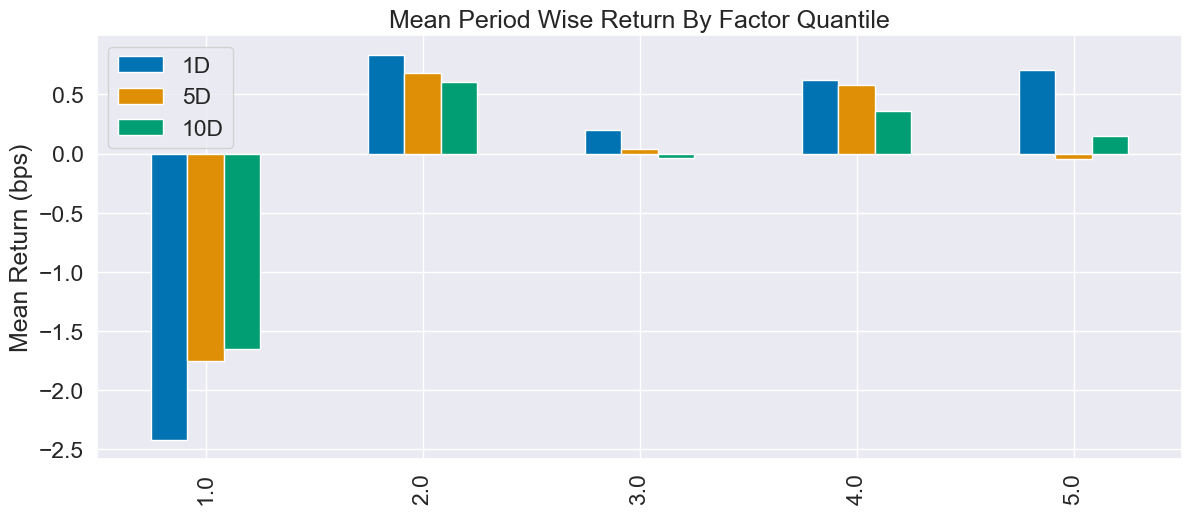

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-9.978304e-01,-0.000074,-0.333388,0.300914,23874,20.137829
2.0,-2.261745e-01,0.000868,-0.001918,0.008382,25236,21.286682
3.0,-2.447001e-06,0.093481,0.002407,0.005308,22042,18.592528
4.0,4.428120e-09,0.496527,0.062133,0.066722,23697,19.988528
5.0,1.181608e-02,0.998530,0.509589,0.294562,23704,19.994433


Returns Analysis


,1D,5D,10D
Ann. alpha,0.064,0.024,0.026
beta,-0.031,-0.039,-0.039
Mean Period Wise Return Top Quantile (bps),0.705,-0.046,0.145
Mean Period Wise Return Bottom Quantile (bps),-2.417,-1.753,-1.654
Mean Period Wise Spread (bps),3.122,1.720,1.815


<Figure size 640x480 with 0 Axes>

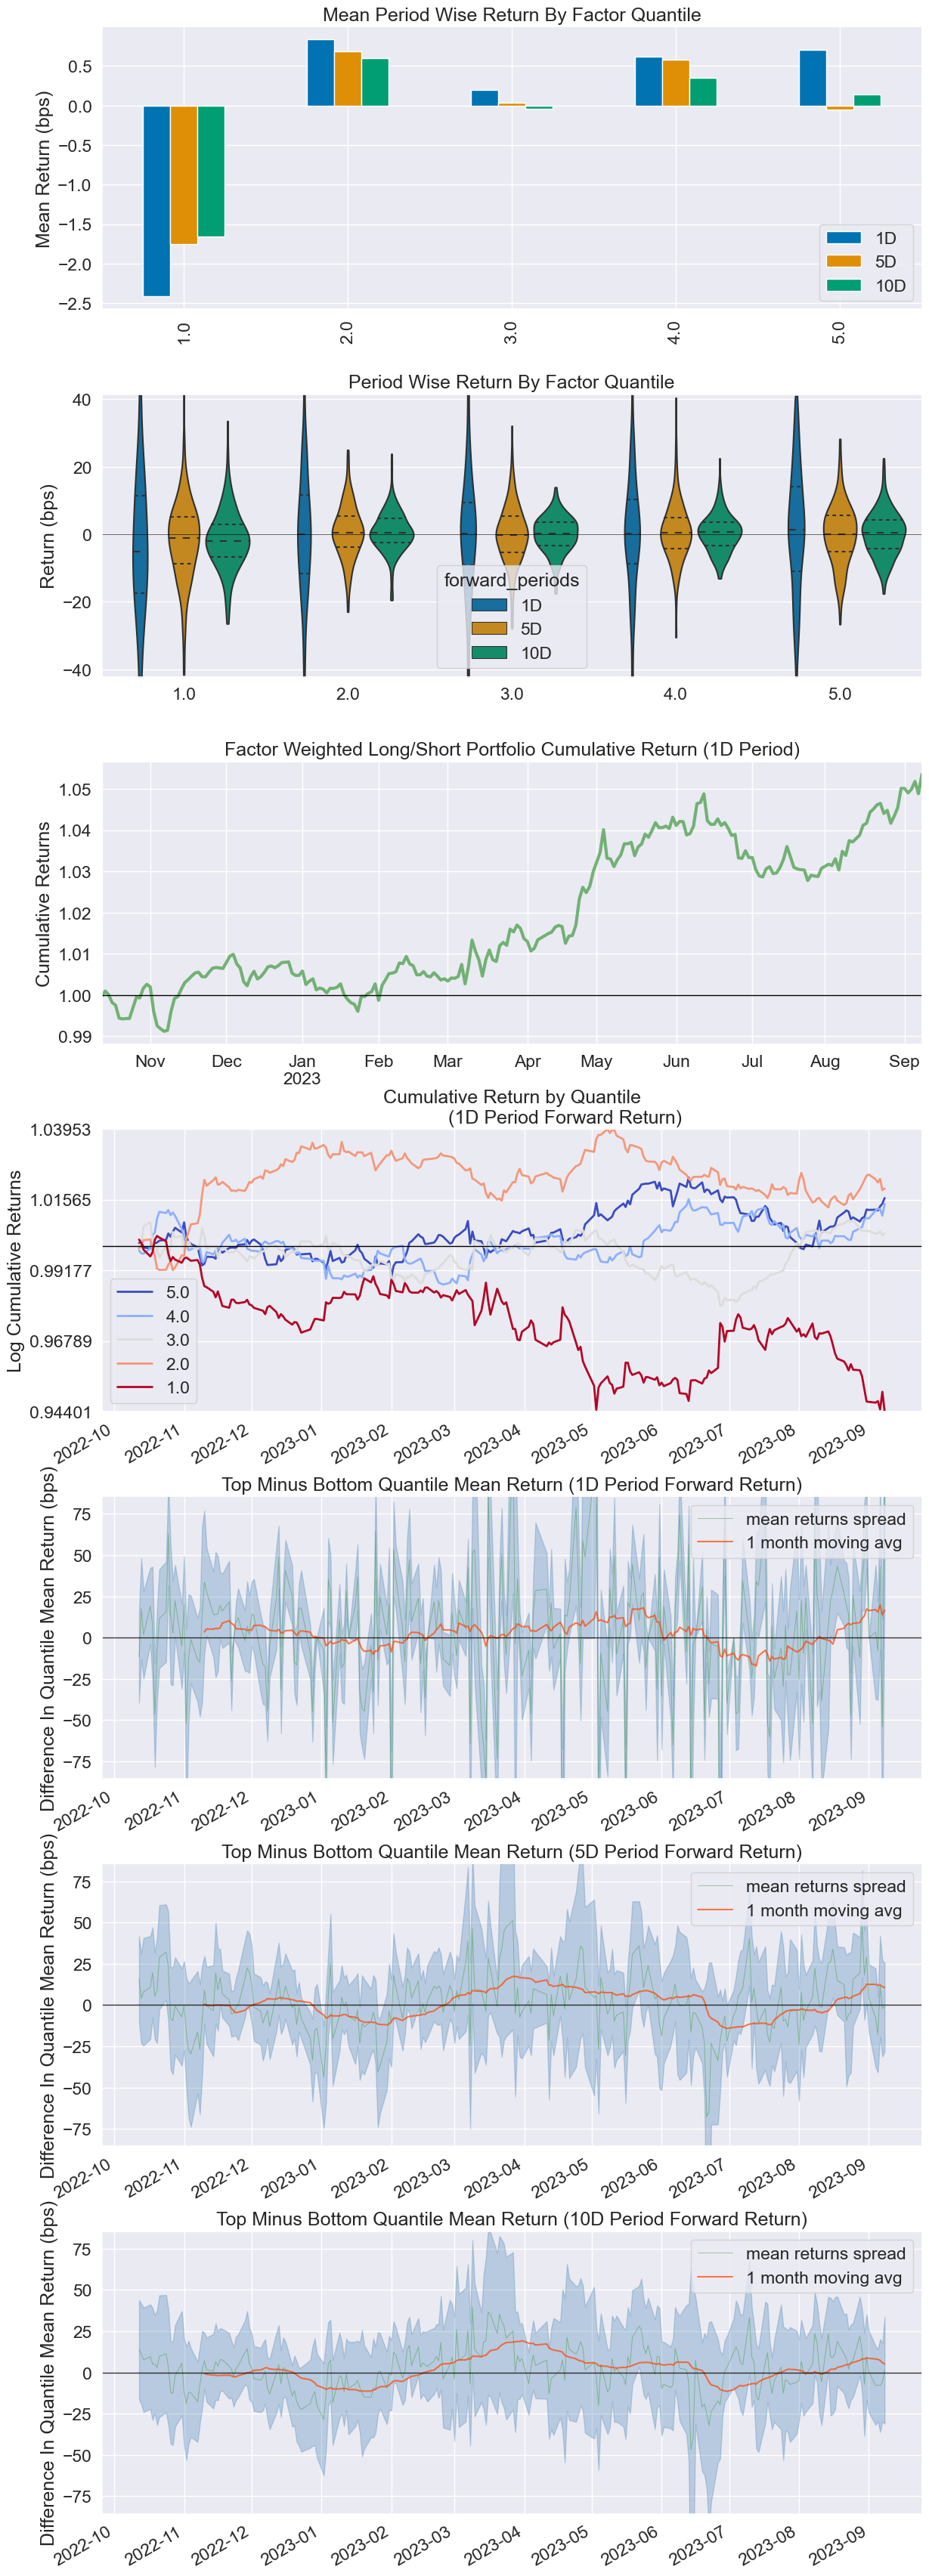

Information Analysis


,1D,5D,10D
IC Mean,0.006,0.004,0.006
IC Std.,0.059,0.063,0.064
Risk-Adjusted IC,0.104,0.067,0.095
t-stat(IC),1.585,1.018,1.458
p-value(IC),0.114,0.310,0.146
IC Skew,-0.168,0.017,-0.002
IC Kurtosis,0.202,-0.009,0.237


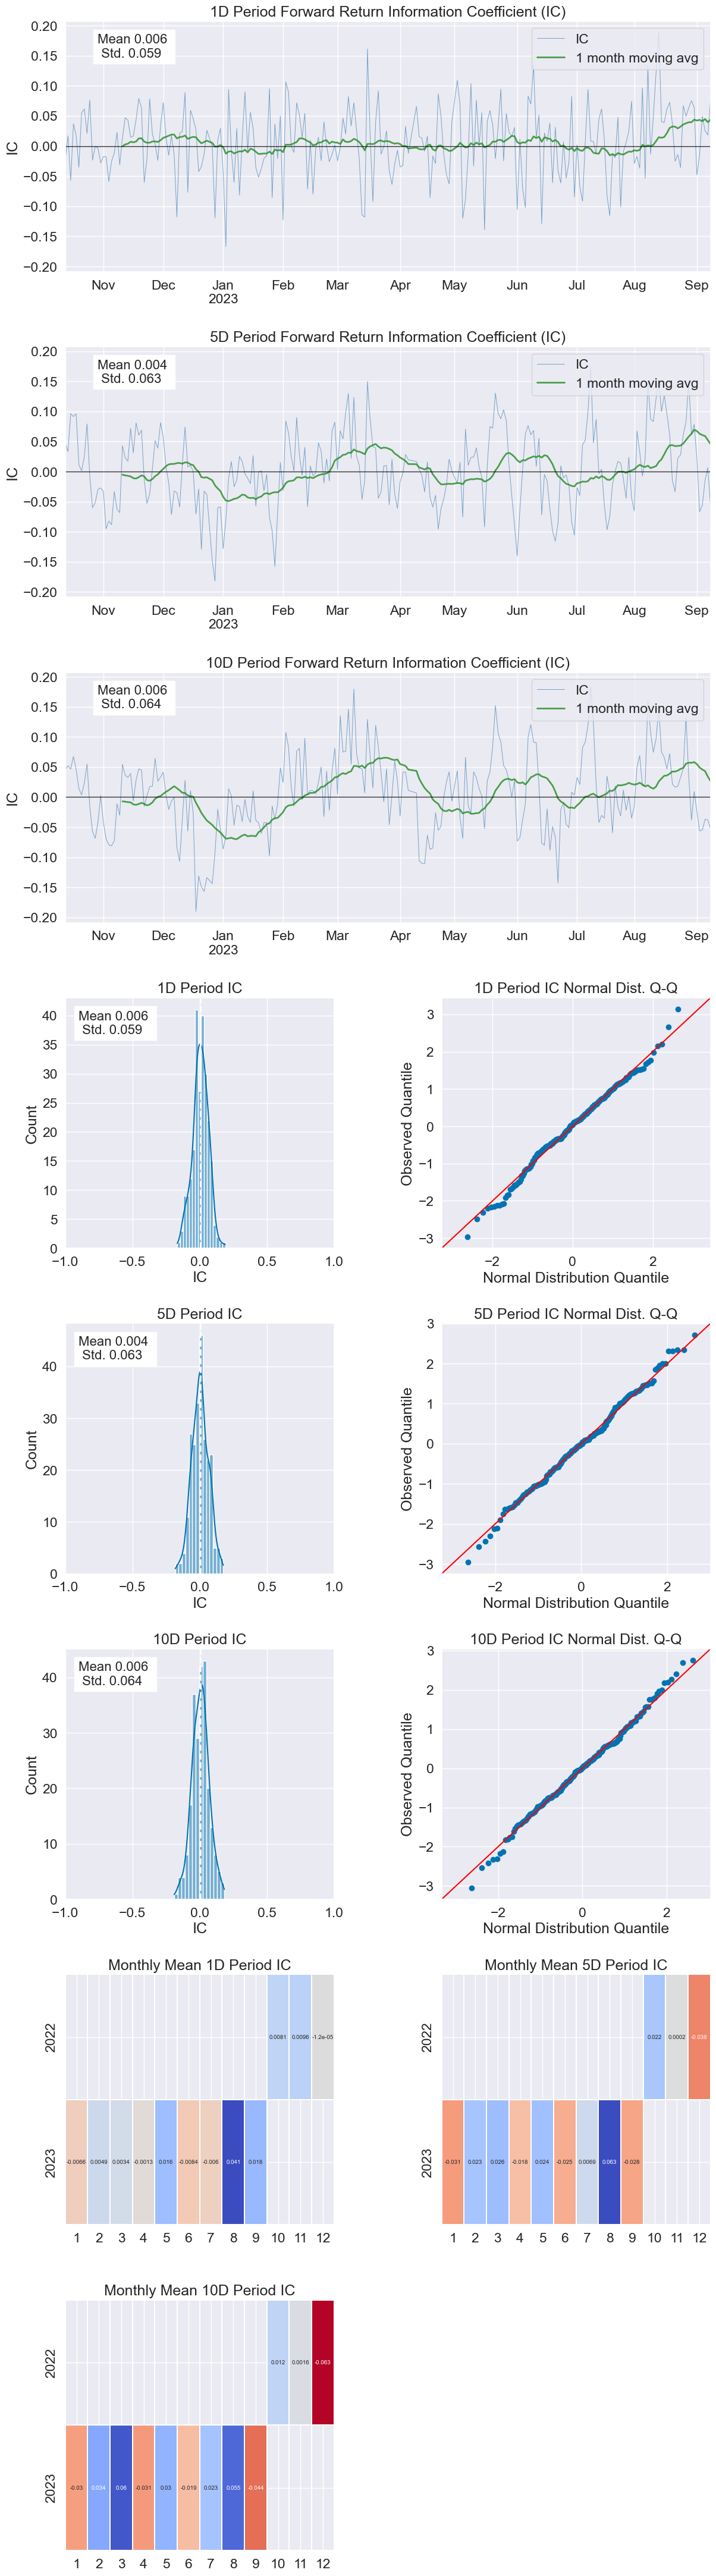

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.288,0.570,0.631
Quantile 2.0 Mean Turnover,0.164,0.399,0.545
Quantile 3.0 Mean Turnover,0.240,0.600,0.740
Quantile 4.0 Mean Turnover,0.353,0.763,0.771
Quantile 5.0 Mean Turnover,0.404,0.723,0.730


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.62,0.269,0.163


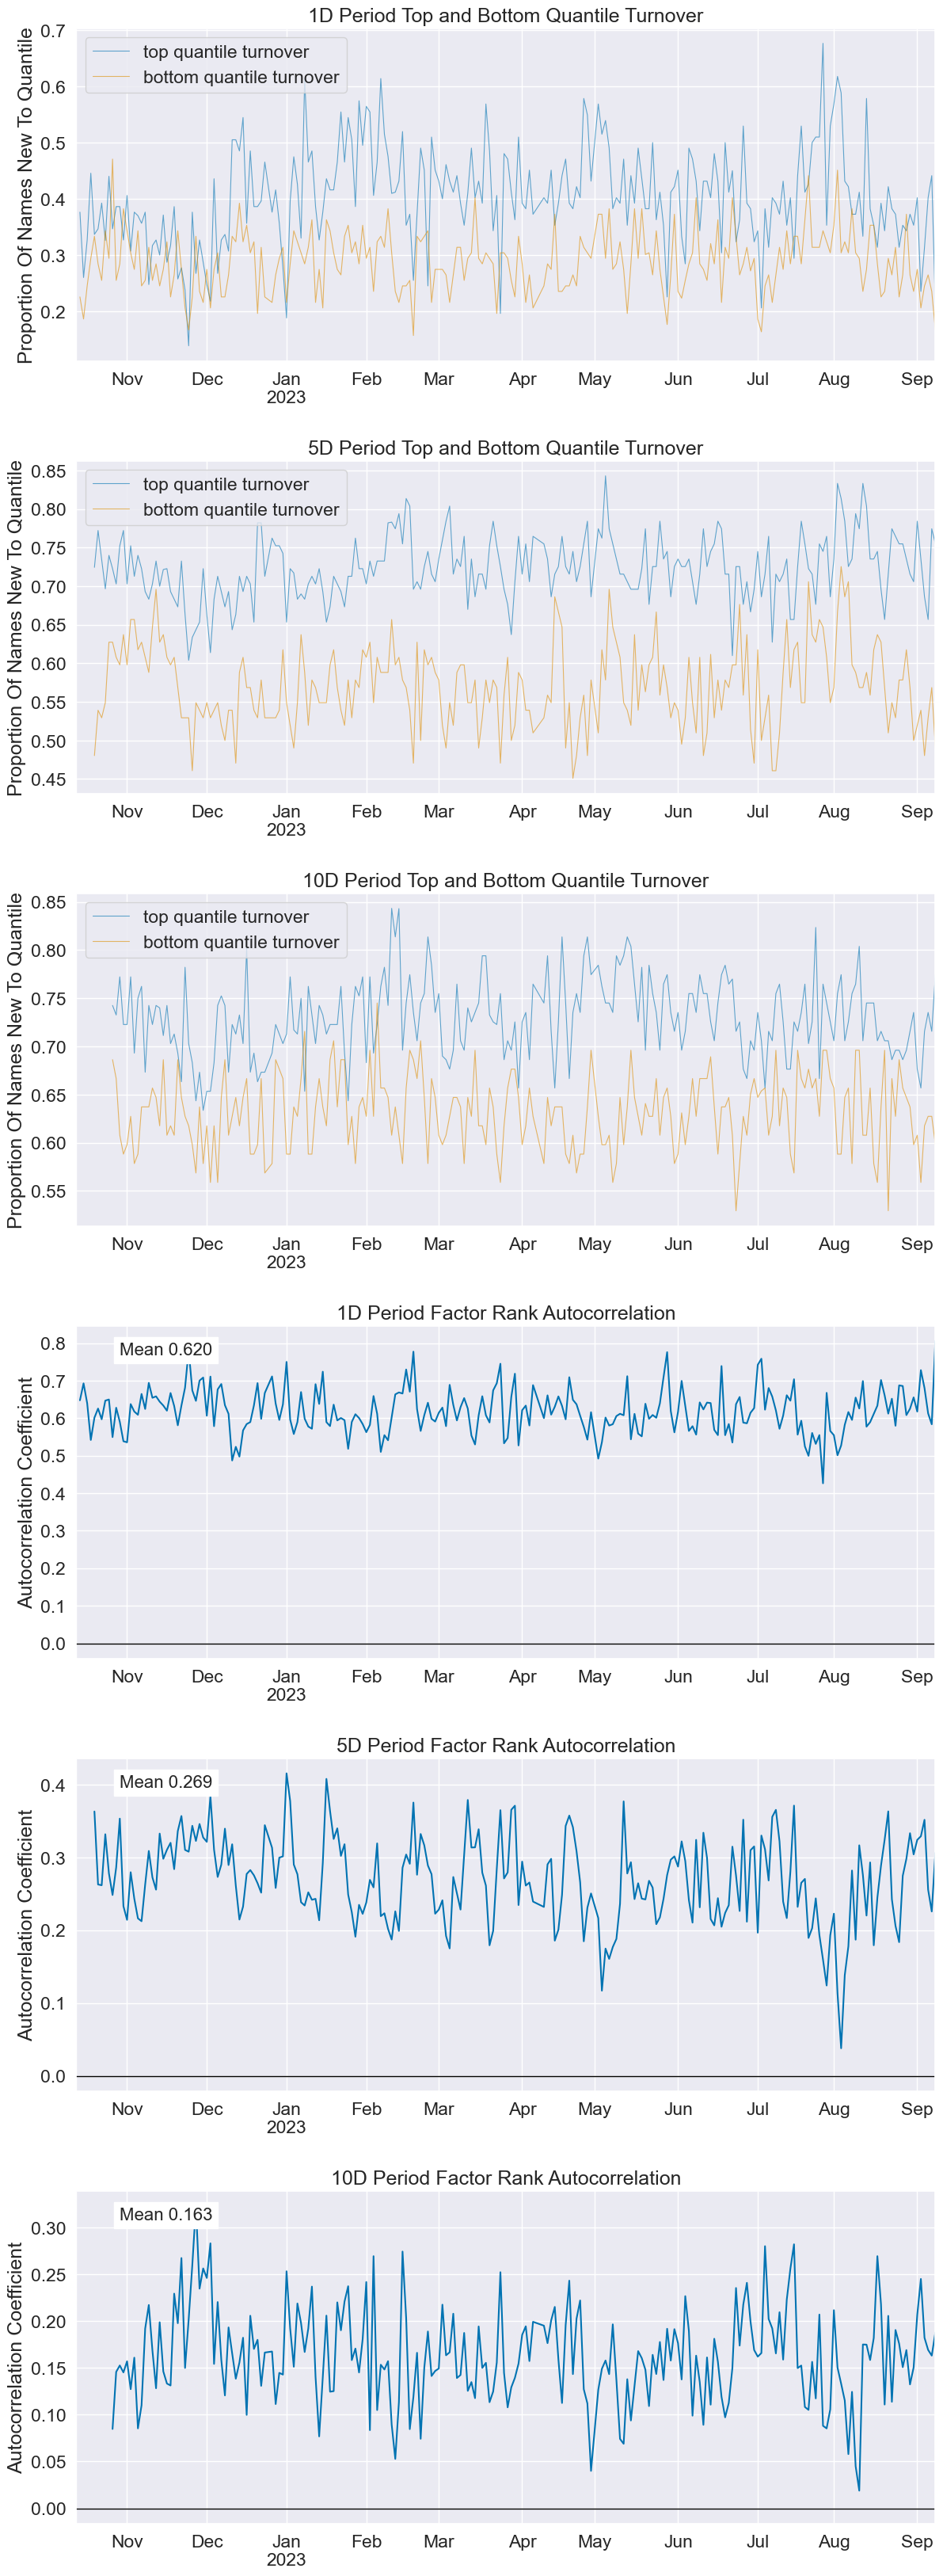

In [30]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=merged_data['Sentiment_Score'],
    prices=prices,
    periods=(1,5,10),
    quantiles= 5,
    bins=None,
    max_loss=0.2
)

factor_data

al.tears.create_summary_tear_sheet(factor_data)

al.tears.create_full_tear_sheet(factor_data)



### Short Long Portfolio Return

In [ ]:
mean_return_by_q.loc[5]-mean_return_by_q.loc[1]